In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import torch
import numpy as np
import torchvision as tv
# import torch.optim as optim
from matplotlib import animation
import matplotlib.pyplot as plt


nn = torch.nn
F = torch.nn.functional
tud = torch.utils.data

/idiap/temp/imitro/miniconda3/envs/length-gen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary cache directory at /idiap/temp/imitro/.cache/pip/matplotlib-0avn4iv3 because the default path (/idiap/home/imitro/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [6]:
parent_dir= os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(parent_dir)

In [8]:
from src.gans import cgan3d
from src.utils import utils
from src.utils.plots import plot_gen
from src.utils.data import GridDataset

In [9]:
utils.seed_everything()

True

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, grid_size=30):
        super(Generator, self).__init__()
        self.grid_size = grid_size
        self.fc = nn.Linear(z_dim + 1, 128)  # z_dim (noise) + 1 for porosity density
        self.conv1 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(512, 27000, kernel_size=3, stride=1, padding=1)

    def forward(self, z, porosity_density):
        # Combine the latent vector with the porosity density
        x = torch.cat([z, porosity_density], dim=1)
        x = self.fc(x)
        x = x.view(-1, 128, 1, 1, 1)  # Reshape to match input to conv layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))  # Final output (probability of pores)
        return x.view(-1, self.grid_size, self.grid_size, self.grid_size)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, grid_size=30):
        super(Discriminator, self).__init__()
        self.grid_size = grid_size
        self.conv1 = nn.Conv3d(2, 64, kernel_size=3, stride=1, padding=1)  # Input: [x, y, z, porosity]
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * grid_size * grid_size * grid_size // 8, 1)  # Fully connected layer to output probability

    def forward(self, real_or_fake_grid, normalized_coords, porosity_density):
        coord_tensor = normalized_coords.view(-1, 3, self.grid_size, self.grid_size, self.grid_size)
        # porosity_tensor = porosity_density.view(-1, 1, 1, 1, 1).expand_as(coord_tensor)
        porosity_tensor = porosity_density.view(-1, 1, 1, 1, 1).expand_as(real_or_fake_grid.unsqueeze(dim=1))
        input_tensor = torch.cat([real_or_fake_grid.unsqueeze(dim=1), porosity_tensor], dim=1)
        
        # input_tensor = torch.cat([real_or_fake_grid.unsqueeze(dim=1), coord_tensor], dim=1)
        # porosity_tensor = porosity_density.view(-1, 1, 1, 1, 1).expand_as(input_tensor)
        # input_tensor += porosity_tensor
        x = F.leaky_relu(self.conv1(input_tensor), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        # import pdb; pdb.set_trace()
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.sigmoid(self.fc(x))  # Output probability between 0 and 1
        return x


In [10]:
def train_gan(generator, discriminator, dataloader, num_epochs=10, z_dim=100, lr_g=5e-5, lr_d=5e-4, beta1=0.5):
    # Optimizers
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    generator = generator.to("cuda")
    discriminator = discriminator.to("cuda")
    generator.train()
    discriminator.train()

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    # Labels for real and fake data
    # real_labels = torch.ones(batch_size, 1).to("cuda") * 0.97  # smoothing
    # fake_labels = torch.zeros(batch_size, 1).to("cuda")
    real_labels = torch.ones(dataloader.batch_size).to("cuda")  #* 0.97  # smoothing
    fake_labels = torch.zeros(dataloader.batch_size).to("cuda")

    real_label = 1.
    fake_label = 0.

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    nz = z_dim
    # fixed_noise = torch.randn(dataloader.batch_size, nz, 1, 1, 1, device="cuda")
    fixed_noise = torch.randn(dataloader.batch_size, nz, device="cuda")

    log_loss_g, log_loss_d, log_loss_d_real, log_loss_d_fake = [], [], [], []
    for epoch in range(num_epochs):
        d_loss_, g_loss_, d_loss_fake_, d_loss_real_ = 0.0, 0.0, 0.0, 0.0
        for i, (real_grid, porosity_factor) in enumerate(dataloader):
            # Move to GPU
            real_grid = real_grid.to("cuda")
            # coord_grid = coord_grid.to("cuda")
            porosity_factor = porosity_factor.to("cuda")
            batch_size = real_grid.size(0)
            
            # Train Discriminator: Real
            # optimizer_d.zero_grad()
            discriminator.zero_grad()
            # real_output = discriminator(real_grid, coord_grid, porosity_factor)
            # import pdb; pdb.set_trace()
            real_output = discriminator(real_grid, porosity_factor.view(-1, 1, 1, 1, 1))
            # real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=real_grid.device)
            d_loss_real = criterion(real_output, real_labels)
            d_loss_real.backward()
            D_x = real_output.mean().item()
            d_loss_real_ += d_loss_real.item()
            
            # Train Discriminator: Fake
            z = torch.randn(batch_size, z_dim).to("cuda")  # Random noise
            # import pdb; pdb.set_trace()
            fake_grids = generator(z, porosity_factor.view(-1, 1))  # Generate fake grids
            # fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=real_grid.device)
            # fake_output = discriminator(fake_grids.detach(), coord_grid, porosity_factor)
            fake_output = discriminator(fake_grids.detach(), porosity_factor.view(-1, 1, 1, 1, 1))
            d_loss_fake = criterion(fake_output, fake_labels) #+ nn.MSELoss()(real_grid, fake_grids)
            d_loss_fake.backward()
            D_G_z1 = fake_output.mean().item()
            d_loss_fake_ += d_loss_fake.item()
            
            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss_ += d_loss.item()
            # d_loss.backward()
            optimizer_d.step()

            # Train Generator: Maximize the probability of fake being real
            generator.zero_grad()
            # fake_labels.fill_(real_label)
            # fake_output = discriminator(fake_grids, coord_grid, porosity_factor)
            fake_output = discriminator(fake_grids, porosity_factor.view(-1, 1, 1, 1, 1))
            g_loss = criterion(fake_output, real_labels) #+ nn.MSELoss()(real_grid, fake_grids)
            g_loss_ += g_loss.item()
            g_loss.backward()
            D_G_z2 = fake_output.mean().item()
            optimizer_g.step()

            # if i % 100 == 0:
                # print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         d_loss.item(), g_loss.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())


             # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = generator(fixed_noise, porosity_factor).detach().cpu()
                    # import pdb; pdb.set_trace()
                img_list.append(tv.utils.make_grid(fake.squeeze(), padding=2, normalize=True))

            iters += 1


        log_loss_d.append(d_loss_ / len(dataloader))
        log_loss_g.append(g_loss_ / len(dataloader))
        log_loss_d_real.append(d_loss_real_ / len(dataloader))
        log_loss_d_fake.append(d_loss_fake_ / len(dataloader))
        print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], D Loss: {log_loss_d[epoch]} = real {log_loss_d_real[epoch]} + fake {log_loss_d_fake[epoch]}, G Loss: {log_loss_g[epoch]}")
    return log_loss_d, log_loss_g, G_losses, D_losses, img_list, generator, discriminator

In [12]:
dataset = GridDataset("../../../Assignment_Data/") 
dataloader = tud.DataLoader(dataset, batch_size=128, shuffle=True)

In [8]:
# Initialize models
z_dim = 256
generator = Generator(z_dim=z_dim)

In [9]:
discriminator = Discriminator()

In [13]:
z_dim = 200
generator = cgan3d.Generator(cube_resolution=30)

In [14]:
discriminator = cgan3d.Discriminator(cube_resolution=30, num_channels=1)

In [15]:
# Train the GAN
log_loss_d, log_loss_g, G_losses, D_losses, img_list, generator, discriminator = train_gan(generator, discriminator, dataloader, num_epochs=400, z_dim=z_dim, lr_g=5e-5, lr_d=5e-3)

[0/400][0/4]	Loss_D: 1.3714	Loss_G: 6.0543	D(x): 0.4951	D(G(z)): 0.4839 / 0.0025
Epoch [0/400], Step [3/4], D Loss: 3.708309143781662 = real 0.3774983980692923 + fake 3.3308106941985898, G Loss: 3.459355371928723
[1/400][0/4]	Loss_D: 2.6277	Loss_G: 6.9139	D(x): 0.4551	D(G(z)): 0.0006 / 0.0010
Epoch [1/400], Step [3/4], D Loss: 1.0472101718187332 = real 1.0147932525724173 + fake 0.032416910253232345, G Loss: 4.3134796023368835
[2/400][0/4]	Loss_D: 0.1225	Loss_G: 4.6631	D(x): 0.9297	D(G(z)): 0.0412 / 0.0098
Epoch [2/400], Step [3/4], D Loss: 0.05633144313469529 = real 0.04002889199182391 + fake 0.016302550910040736, G Loss: 5.417465686798096
[3/400][0/4]	Loss_D: 0.0153	Loss_G: 6.0246	D(x): 0.9885	D(G(z)): 0.0035 / 0.0025
Epoch [3/400], Step [3/4], D Loss: 0.013028969522565603 = real 0.00829919392708689 + fake 0.004729775479063392, G Loss: 5.979286432266235
[4/400][0/4]	Loss_D: 0.0187	Loss_G: 6.6609	D(x): 0.9964	D(G(z)): 0.0136 / 0.0015
Epoch [4/400], Step [3/4], D Loss: 0.008131011156365

KeyboardInterrupt: 

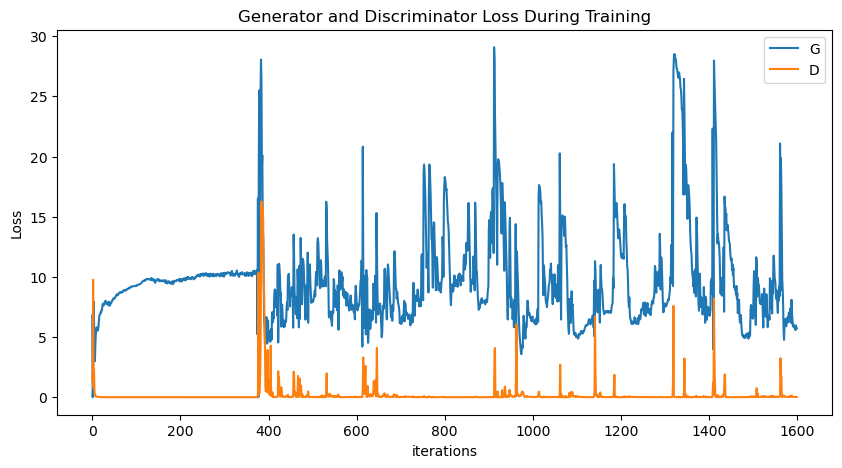

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
for img in img_list:
    print(img.shape)

torch.Size([30, 514, 258])
torch.Size([30, 514, 258])
torch.Size([30, 514, 258])
torch.Size([30, 514, 258])
torch.Size([30, 514, 258])


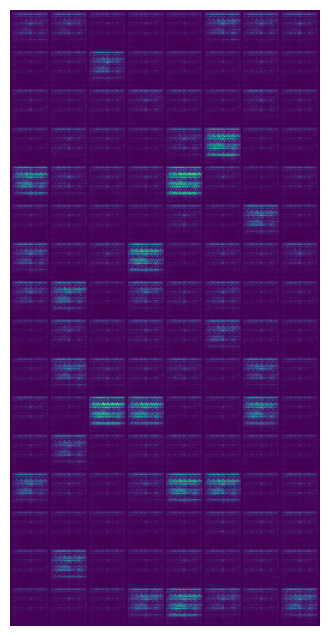

In [44]:
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0))[:, :, 0], animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

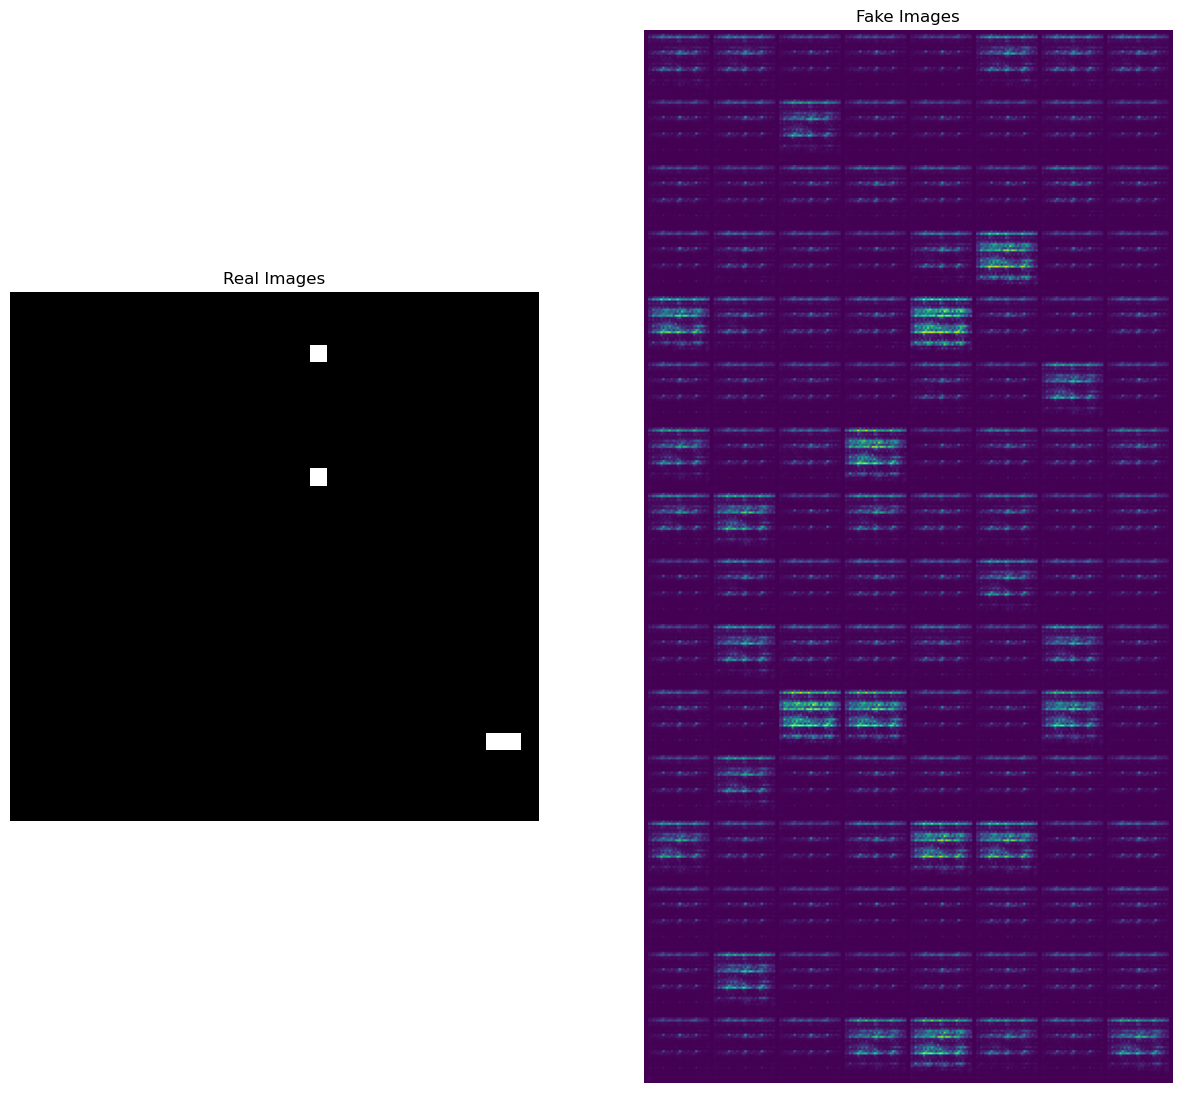

In [49]:
# Grab a batch of real images from the dataloader
real_img, real_density = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(tv.utils.make_grid(real_img[0][:, :, 2], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0))[:, :, 2])
plt.show()

In [31]:
index = 327
grid_truth, density_factor = dataset.__getitem__(index)

In [32]:
generator.eval()
with torch.no_grad():
    recon = generator(torch.randn(1, 200).to("cuda"), density_factor.view(-1, 1).to("cuda")).squeeze()

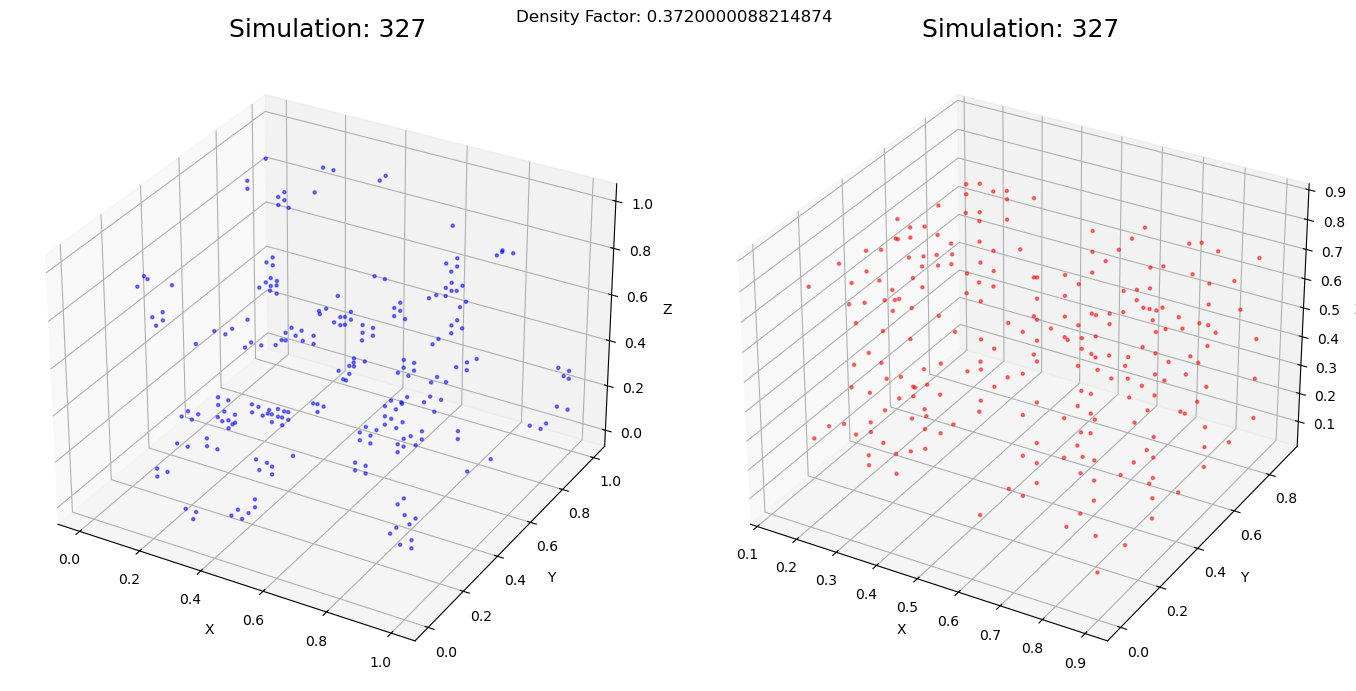

In [33]:
plot_gen(grid_truth.squeeze(), recon, index1=index, index2=index, density=density_factor.item())